# Sesión 2 Foundation models y modelos generativos
##### Héctor Hugo Coronado Huamán


# Stable Diffusion Inference using HuggingFace

This notebook aims to show you how to run a Stable Diffusion model using the `diffusers` library from HuggingFace.

More information in: https://huggingface.co/docs/diffusers/en/quicktour

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Check that the GPU is working

In [ ]:
! nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


## Install Diffusers library

Here is the command to install diffusers, transformers, torch and accelerate libs:

## Import libraries

In [1]:
import os
import tensorflow as tf
import torch

from PIL import Image

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

import warnings
warnings.filterwarnings('ignore')

## Create an output folder

Check if output directory exists. If folder doesn't exist, then create it:

In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/stable_diff/'

if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Select model and parameters

Stable Diffusion models in HuggingFace:
- https://huggingface.co/CompVis/stable-diffusion-v1-4
- https://huggingface.co/runwayml/stable-diffusion-v1-5

In [2]:
def get_device():
    return "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Model parameters ----------------------------------------
#MODEL_ID = "stabilityai/stable-diffusion-2"
# MODEL_ID = "runwayml/stable-diffusion-v1-5"
MODEL_ID = "CompVis/stable-diffusion-v1-4"

# GPU parameters  ----------------------------------------
#DEVICE = "cuda"
DEVICE = get_device()  # Use cuda to run on GPU

# Scheduler parameters ----------------------------------------
SCHEDULER = "EULER_ANCESTRAL"  # Choose from ["EULER_ANCESTRAL", "EULER", "DDIMS", "K-LMS", "PNDM"]
BETA_END = 0.012
BETA_SCHEDULE = "scaled_linear"
BETA_START = 0.00085

## Pipeline creation with a specific scheduler

If you have small GPU (less than 10GB) then you must use `float16` precision instead of `float32`.

More info about schedulers: https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers


In [ ]:
from diffusers import (
    StableDiffusionPipeline,
    DDIMScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
)

def create_pipeline(model_id):

    SCHEDULER_MAP = {
        "DDIMS": DDIMScheduler,
        "EULER_ANCESTRAL": EulerAncestralDiscreteScheduler,
        "EULER": EulerDiscreteScheduler,
        "K-LMS": LMSDiscreteScheduler,
        "PNDM": PNDMScheduler,
    }

    scheduler = SCHEDULER_MAP[SCHEDULER](
        beta_start=BETA_START,
        beta_end=BETA_END,
        beta_schedule=BETA_SCHEDULE
    )

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        scheduler=scheduler,
        # torch_dtype=torch.float32,
        # safety_checker=None,   NSFW = NOT SAFE FOR WORK
    ).to(DEVICE)

    return pipe

The `safety_checker` parameter is to filter out unsafe content from generated images. If enabled it returns a completely black image when the generated image violates certain rules, the "NSFW" (not safe for work) concept embeddings generated from CLIP

### Create a new pipeline. This can take a few minutes... be patient :)

In [ ]:
pipe = create_pipeline(model_id=MODEL_ID)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
INFERENCE_SEED = 1234512345

# Set seed
custom_generator = torch.Generator(device=DEVICE).manual_seed(INFERENCE_SEED)

## Tarea 1. Generar imágenes

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def generate_images_grid(pipe, prompt, negative_prompt="", num_images=5, steps=50, h=512, w=512, guidance_scale=7.5, strength=0.75, seed=custom_generator, save_image=True):

    print(prompt)

    images = pipe(
        num_images * [prompt],
        height=h,
        width=w,
        negative_prompt=num_images * [negative_prompt],
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
        strength=strength,
        generator=seed
    ).images

    grid = image_grid(images, rows=len(images), cols=1)

    if save_image==True:
        outfilename = f'{OUTPUT_DIR}/' + f'{INFERENCE_SEED}_grid_' + prompt.replace(' ', '_') + '.png'
        grid.save(outfilename)

    display(grid)


A deep dark castle with mountains, beautiful architecture, surrounded by forest, quiet place, dark ambient portrait photography photography--beta --ar 2:3  --beta --upbeta


  0%|          | 0/20 [00:00<?, ?it/s]

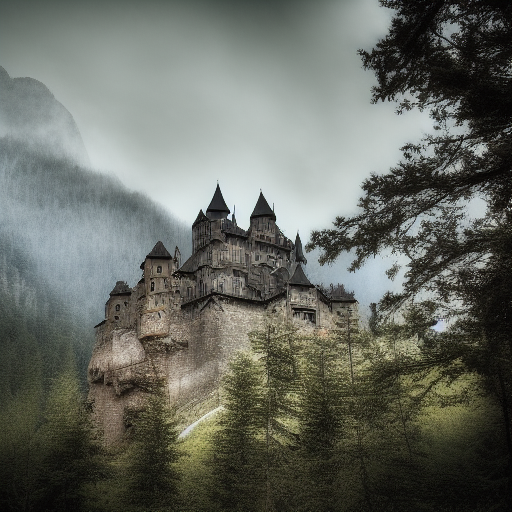

In [ ]:
prompt = "A deep dark castle with mountains, beautiful architecture, surrounded by forest, quiet place, dark ambient portrait photography"
prompt += " photography--beta --ar 2:3  --beta --upbeta"

pipe.enable_attention_slicing()

generate_images_grid(
    pipe,
    prompt,
    num_images=1,
    steps=20,
    seed=custom_generator,
    save_image=False
)

Buscando algunos métodos para generar imágenes de mayor calidad encontré [esta página](https://huggingface.co/docs/diffusers/en/stable_diffusion) en la cual aparecen algunos ajustes para mejorarlas



---

## Tarea 2. Diseñar historia de un comic


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    device_map="auto",
)

model.to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.
You shouldn't move a model that is dispatched using accelerate hooks.


RuntimeError: You can't move a model that has some modules offloaded to cpu or disk.

In [ ]:
input_text = "Create an adventure story about a female searching for a treasure."
input_ids = tokenizer(input_text, return_tensors="pt").to(DEVICE)

outputs = model.generate(**input_ids, max_new_tokens=320)
print(tokenizer.decode(outputs[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': '<BOS> <action> Two adventurers travel to the island of Tira where one is led by Tetsuya, the most wanted man in the world. The other is Natsu, a merchant who has only his sword to his name. Upon arrival, the two travel to Tira where they meet the beautiful Lady Biku, a witch who claims to be the last descendant of Surya.'}]
